## **Import necessary libraries**

In [1]:
import pandas as pd
import numpy as np

### **LOAD THE DATASET(32M ratings)**

In [2]:
df_movie=pd.read_csv('/home/harley/Documents/ML_AT_SCALE_CODE/ml-32m/movies.csv')
df_rating=pd.read_csv('/home/harley/Documents/ML_AT_SCALE_CODE/ml-32m/ratings.csv')

In [3]:

df_movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_rating.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [6]:
df_movie.shape,df_rating.shape

((87585, 3), (32000204, 4))

In [9]:
# Extract user, movie, and rating arrays
users = df_rating['userId'].values
movies = df_rating['movieId'].values
ratings = df_rating['rating'].values

# Initialize index dictionaries and lists
movie_index_dict = {}
user_index_dict = {}
user_lst = []
movie_lst = []
user_data = []  
movie_data = []  

# Create indexing
for user, movie, rating in zip(users, movies, ratings):
    # For Users
    if user not in user_index_dict:
        n = len(user_lst)  
        user_index_dict[user] = n
        user_lst.append(user)
        user_data.append([])  
    else:
        n = user_index_dict[user]

    # For Movies
    if movie not in movie_index_dict:
        m = len(movie_lst)  
        movie_index_dict[movie] = m
        movie_lst.append(movie)
        movie_data.append([])  # Initialize a new list for this movie

    # Append the rating info as tuples (movie index, rating) for the user
    user_data[n].append((movie_index_dict[movie], rating))
    # Append the rating info as tuples (user index, rating) for the movie
    movie_data[m].append((user_index_dict[user], rating))




In [7]:
len(user_data),len(movie_data)

(200948, 84432)

### **Vizualisation**

#### **Rating distribution**

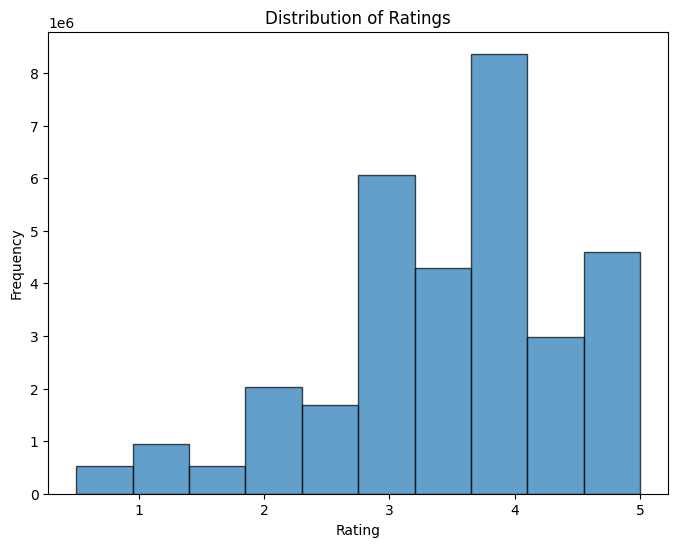

In [13]:
import matplotlib.pyplot as plt

# Plot rating distribution
plt.figure(figsize=(8, 6))
plt.hist(df_rating['rating'], bins=10, edgecolor='k', alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.savefig("images/rating_distribution.pdf")
plt.show()


#### **Power Law**

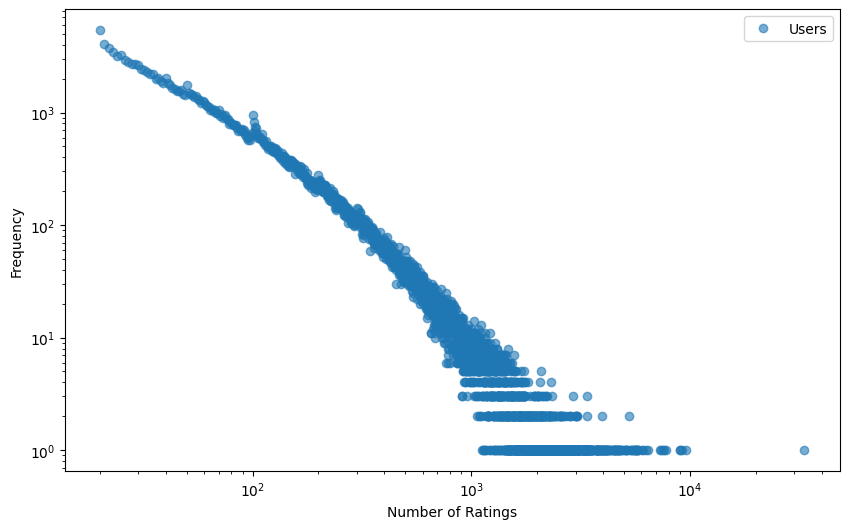

In [14]:
# Number of ratings per user
ratings_per_user = df_rating.groupby('userId').size()
ratings_per_movie = df_rating.groupby('movieId').size()

# Plot user rating distribution on a log-log scale
plt.figure(figsize=(10, 6))
plt.loglog(ratings_per_user.value_counts().sort_index(), marker='o', linestyle='None', alpha=0.6, label='Users')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.legend()
plt.savefig("images/user_ratings_powerlaw.pdf")
plt.show()


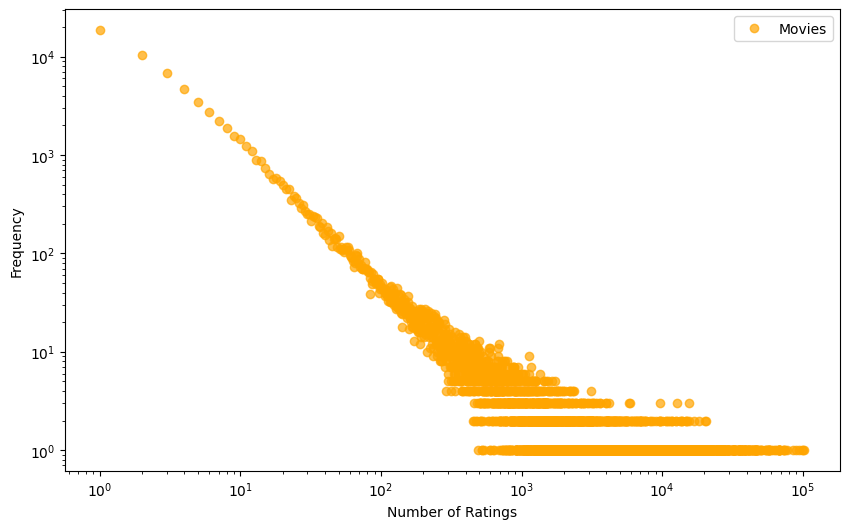

In [15]:
plt.figure(figsize=(10, 6))
plt.loglog(ratings_per_movie.value_counts().sort_index(), marker='o', color='orange' ,linestyle='None', alpha=0.7, label='Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.legend()
plt.savefig("images/movie_ratings_powerlaw.pdf")
plt.show()


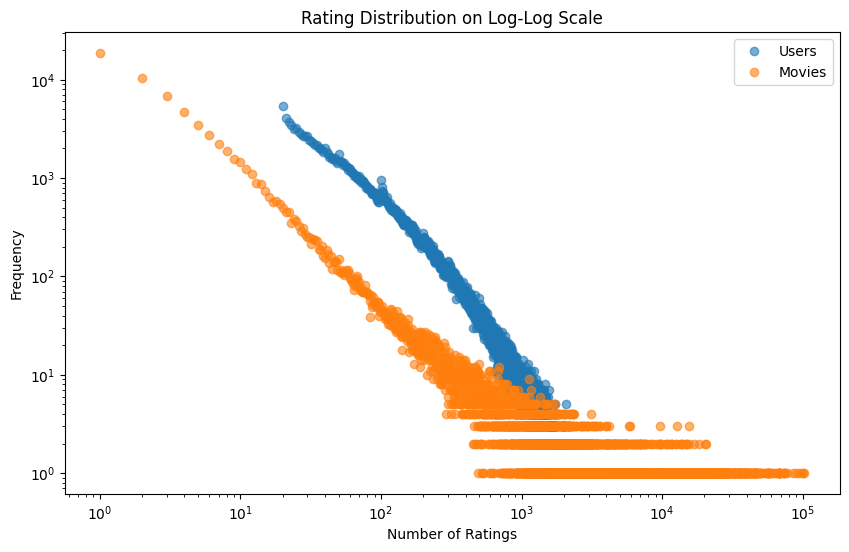

In [16]:
## Plot user rating distribution on a log-log scale
plt.figure(figsize=(10, 6))
plt.loglog(ratings_per_user.value_counts().sort_index(), marker='o', linestyle='None', alpha=0.6, label='Users')
plt.loglog(ratings_per_movie.value_counts().sort_index(), marker='o', linestyle='None', alpha=0.6, label='Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.title('Rating Distribution on Log-Log Scale')
plt.legend()
plt.savefig("images/powerlaw.pdf")
plt.show()


# **TRAINING ON SMALL DATASET MOVIELENS(100K)**

## **BIAS ONLY**

In [118]:
df_rating_small = pd.read_csv('/home/harley/Documents/ML_AT_SCALE_CODE/ml-latest-small/ratings.csv')

In [119]:
users = df_rating_small['userId'].values
movies = df_rating_small['movieId'].values
ratings = df_rating_small['rating'].values


### **Split data into train set and test set**

In [120]:
data_by_user_train = []
data_by_user_test = []
data_by_movie_train = []
data_by_movie_test = []

movie_index_dict = {}
user_index_dict = {}
user_lst = []
movie_lst = []
user_data_train = []
user_data_test = []
movie_data_train = []
movie_data_test = []


for user, movie, rating in zip(users, movies, ratings):
    # For Users
    if user not in user_index_dict:
        n = len(user_lst)
        user_index_dict[user] = n
        user_lst.append(user)
        data_by_user_train.append([])
        data_by_user_test.append([])
    else:
        n = user_index_dict[user]

    # For Movies
    if movie not in movie_index_dict:
        m = len(movie_lst)
        movie_index_dict[movie] = m
        movie_lst.append(movie)
        data_by_movie_train.append([])
        data_by_movie_test.append([])
    if np.random.rand() < 0.9:
        data_by_user_train[n].append((movie_index_dict[movie], rating))
        data_by_movie_train[m].append((n, rating))
    else:
        data_by_user_test[n].append((movie_index_dict[movie], rating))
        data_by_movie_test[m].append((n, rating))


In [82]:
len(data_by_user_train),len(data_by_movie_train),len(data_by_user_test) , len(data_by_movie_test)

(610, 9724, 610, 9724)

#### **Training....**

In [84]:
def compute_loss_and_rmse(data_by_user, user_biases, movie_biases, lambda_reg, gamma):
    error = 0
    total_ratings = 0
    for user_id in range(len(user_biases)):
        for (movie_id, rating) in data_by_user[user_id]:
            predicted_rating = user_biases[user_id] + movie_biases[movie_id]
            error += (rating - predicted_rating) ** 2
            total_ratings += 1

    # egularized loss 
    loss = error *lambda_reg
    loss += tau * (np.sum(user_biases**2) + np.sum(movie_biases**2))
    loss/=2


    # rmse
    rmse = np.sqrt(loss / total_ratings) if total_ratings > 0 else 0

    return loss, rmse


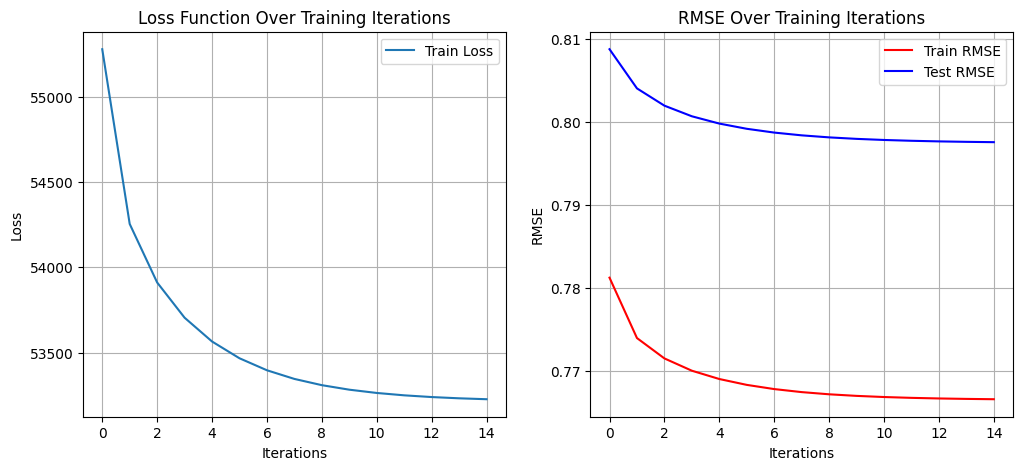

In [85]:
num_users = len(user_lst)
num_movies = len(movie_lst)

user_biases = np.zeros(num_users)
movie_biases = np.zeros(num_movies)
lambda_reg = 1
tau = 0.001
gamma = 0.1

num_iterations = 15

train_loss_history = []
train_rmse_history = []
test_loss_history = []
test_rmse_history = []

for iteration in range(num_iterations):

    # Update user biases
    for user_id in range(num_users):
        bias_sum = 0
        item_count = 0
        for (movie_id, rating) in data_by_user_train[user_id]:
            bias_sum += lambda_reg*(rating - movie_biases[movie_id])
            item_count += 1 
        user_biases[user_id] = bias_sum / (lambda_reg * item_count + gamma)


    # Update movie biases
    for movie_id in range(num_movies):
        bias_sum = 0
        user_count = 0
        for (user_id, rating) in data_by_movie_train[movie_id]:
            bias_sum += lambda_reg*(rating - user_biases[user_id])
            user_count += 1 
        movie_biases[movie_id] = bias_sum / (lambda_reg * user_count + gamma)


   
    train_loss, train_rmse = compute_loss_and_rmse(
        data_by_user_train, user_biases, movie_biases, lambda_reg, gamma
    )
    train_loss_history.append(train_loss)
    train_rmse_history.append(train_rmse)

    # Compute testing loss and RMSE
    test_loss, test_rmse = compute_loss_and_rmse(
        data_by_user_test, user_biases, movie_biases, lambda_reg, gamma
    )
    test_loss_history.append(test_loss)
    test_rmse_history.append(test_rmse)   

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.title('Loss Function Over Training Iterations')

plt.subplot(1, 2, 2)
plt.plot(train_rmse_history, label='Train RMSE', color='red')
plt.plot(test_rmse_history, label='Test RMSE', color='blue')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.title('RMSE Over Training Iterations')
plt.savefig("images/100k_bias_onlyloss_rmse_training.pdf")
plt.show()


## **BIAS + LATENT FACTORS**

#### **1st case:num_factors=10,gamma=0.001,lambda=0.8,tau=0.5**

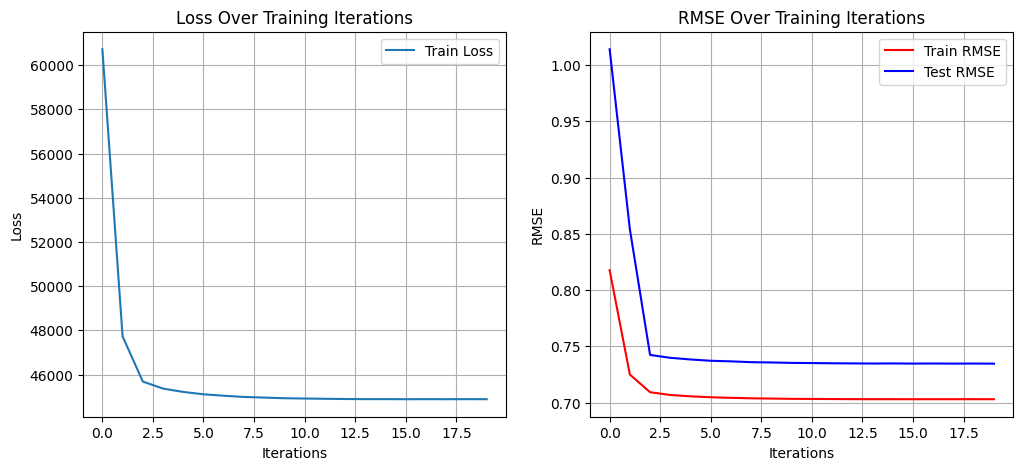

In [121]:
import numpy as np
import matplotlib.pyplot as plt


k = 10  
num_iterations = 20  
gamma = 0.001
lambda_reg = 0.8
tau = 0.5

# Number of users and movies
num_users = len(user_lst)
num_movies = len(movie_lst)

# Initialize biases and latent vectors
user_biases = np.zeros(num_users)
item_biases = np.zeros(num_movies)


k = k  


user_vectors = np.random.normal(0, 1/np.sqrt(k), (num_users, k))  
item_vectors = np.random.normal(0, 1/np.sqrt(k), (num_movies, k))  


# Track training and test loss, RMSE
train_loss_history = []
train_rmse_history = []
test_rmse_history = []

def loss_cost_rms(users_map, users_vector, movies_vector, item_biases, user_biases, lambda_reg, tau, gamma):
    """Compute loss and RMSE for training or test data."""
    result = 0
    count = 0
    M = len(users_map)
    
    # Calculate squared error sum
    for m in range(M):
        for (n, r) in users_map[m]:
            result += (r - np.dot(users_vector[m], movies_vector[n]) - item_biases[n] - user_biases[m]) ** 2
            count += 1

    # Compute the regularization terms
    loss = result * lambda_reg
    loss += gamma * np.sum(item_biases ** 2) + gamma * np.sum(user_biases ** 2)
    loss += tau * (np.einsum('ij,ij->', users_vector, users_vector)) + tau * (np.einsum('ij,ij->', movies_vector.T, movies_vector.T))
    loss = loss / 2  
    # Compute RMSE
    rms = np.sqrt(loss / count)
    
    return loss, rms

# ALS iterations
for iteration in range(num_iterations):
    # Update user biases and vectors
    for user_idx in range(num_users):
        bias_sum = 0
        item_counter = 0
        A = np.zeros((k, k))
        b = np.zeros(k)
        
        for movie_idx, rating in data_by_user_train[user_idx]:
            bias_sum += lambda_reg * (rating - item_biases[movie_idx])
            item_counter += 1
            prediction_error = rating - user_biases[user_idx] - item_biases[movie_idx]
            A += np.outer(item_vectors[movie_idx], item_vectors[movie_idx])  
            b += prediction_error * item_vectors[movie_idx]  
        
        user_biases[user_idx] = bias_sum / (lambda_reg * item_counter + gamma)
        user_vectors[user_idx] = np.linalg.solve(lambda_reg * A + tau * np.eye(k), lambda_reg * b)

    # Update item biases and vectors
    for movie_idx in range(num_movies):
        bias_sum = 0
        user_counter = 0
        A = np.zeros((k, k))
        b = np.zeros(k)
        
        for user_idx, rating in data_by_movie_train[movie_idx]:
            bias_sum += lambda_reg * (rating - user_biases[user_idx])
            user_counter += 1
            prediction_error = rating - user_biases[user_idx] - item_biases[movie_idx]
            A += np.outer(user_vectors[user_idx], user_vectors[user_idx]) 
            b += prediction_error * user_vectors[user_idx]
        
        item_biases[movie_idx] = bias_sum / (lambda_reg * user_counter + gamma)
        item_vectors[movie_idx] = np.linalg.solve(lambda_reg * A + tau * np.eye(k), lambda_reg * b)

    train_loss, train_rmse = loss_cost_rms(
        data_by_user_train, user_vectors, item_vectors, item_biases, user_biases, lambda_reg, tau, gamma
    )
    train_loss_history.append(train_loss)
    train_rmse_history.append(train_rmse)

    _, test_rmse = loss_cost_rms(
        data_by_user_test, user_vectors, item_vectors, item_biases, user_biases, lambda_reg, tau, gamma
    )
    test_rmse_history.append(test_rmse)

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.title('Loss Over Training Iterations')

# rmse Plot
plt.subplot(1, 2, 2)
plt.plot(train_rmse_history, label='Train RMSE', color='red')
plt.plot(test_rmse_history, label='Test RMSE', color='blue')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.title('RMSE Over Training Iterations')

plt.savefig("images/100k_bias_+_latent_vectors_loss_rmse1.pdf")
plt.show()


# **ALS ON 32M DATASET**

In [36]:
df_movie=pd.read_csv('/home/harley/Documents/ML_AT_SCALE_CODE/ml-32m/movies.csv')
df_rating=pd.read_csv('/home/harley/Documents/ML_AT_SCALE_CODE/ml-32m/ratings.csv')

In [37]:
# Extract user, movie, and rating arrays
users = df_rating['userId'].values
movies = df_rating['movieId'].values
ratings = df_rating['rating'].values

### **SPLIT DATA INTO TRAINSET AND TESTSET**

In [38]:
movie_index_dict = {}
user_index_dict = {}
user_lst = []
movie_lst = []

# Create mappings for user and movie indices
for user, movie, rating in zip(users, movies, ratings):

    # Map unique users
    if user not in user_index_dict:
        user_index = len(user_lst)
        user_index_dict[user] = user_index
        user_lst.append(user)

    # Map unique movies
    if movie not in movie_index_dict:
        movie_index = len(movie_lst)
        movie_index_dict[movie] = movie_index
        movie_lst.append(movie)

# Number of unique users and movies
num_users = len(user_lst)
num_movies = len(movie_lst)

user_movie_ratings = [
    (user_index_dict[user], movie_index_dict[movie], rating)
    for user, movie, rating in zip(users, movies, ratings)
]

# Convert the list to a structured NumPy array
user_movie_ratings = np.array(
    user_movie_ratings, dtype=[('user_idx', np.int32), ('movie_idx', np.int32), ('rating', np.float64)]
)

# Initialize training and testing sets (90% train, 10% test) for users and movies
data_by_user_train = [[] for _ in range(num_users)]
data_by_user_test = [[] for _ in range(num_users)]
data_by_movie_train = [[] for _ in range(num_movies)]
data_by_movie_test = [[] for _ in range(num_movies)]

# Split data into training and testing sets
for user, movie, rating in zip(users, movies, ratings):
    user_index = user_index_dict[user]
    movie_index = movie_index_dict[movie]

    if np.random.rand() < 0.9:  # 90% chance to go into training
        data_by_user_train[user_index].append((movie_index, rating))
        data_by_movie_train[movie_index].append((user_index, rating))
    else:  # 10% chance to go into testing
        data_by_user_test[user_index].append((movie_index, rating))
        data_by_movie_test[movie_index].append((user_index, rating))

# Convert lists of tuples to structured NumPy arrays for fast access
data_by_user_train = [
    np.array(data, dtype=[('movie_idx', np.int32), ('rating', np.float64)])
    for data in data_by_user_train
]
data_by_user_test = [
    np.array(data, dtype=[('movie_idx', np.int32), ('rating', np.float64)])
    for data in data_by_user_test
]
data_by_movie_train = [
    np.array(data, dtype=[('user_idx', np.int32), ('rating', np.float64)])
    for data in data_by_movie_train
]
data_by_movie_test = [
    np.array(data, dtype=[('user_idx', np.int32), ('rating', np.float64)])
    for data in data_by_movie_test
]


In [6]:
len(data_by_user_train),len(data_by_movie_train),len(data_by_user_test),len(data_by_movie_test)

(200948, 84432, 200948, 84432)

# **BIAS ONLY**

In [6]:
import numpy as np
from numba import njit, prange
import matplotlib.pyplot as plt
import time



Starting training
Iteration 1/10, Time: 55.5930s, Train RMSE: 0.8618, Test RMSE: 0.8706
Iteration 2/10, Time: 27.7789s, Train RMSE: 0.8470, Test RMSE: 0.8560
Iteration 3/10, Time: 28.2125s, Train RMSE: 0.8463, Test RMSE: 0.8553
Iteration 4/10, Time: 27.7180s, Train RMSE: 0.8462, Test RMSE: 0.8552
Iteration 5/10, Time: 26.2515s, Train RMSE: 0.8462, Test RMSE: 0.8552
Iteration 6/10, Time: 29.7122s, Train RMSE: 0.8462, Test RMSE: 0.8552
Iteration 7/10, Time: 26.3676s, Train RMSE: 0.8462, Test RMSE: 0.8552
Iteration 8/10, Time: 26.5504s, Train RMSE: 0.8462, Test RMSE: 0.8552
Iteration 9/10, Time: 26.0960s, Train RMSE: 0.8462, Test RMSE: 0.8552
Iteration 10/10, Time: 28.8010s, Train RMSE: 0.8462, Test RMSE: 0.8552


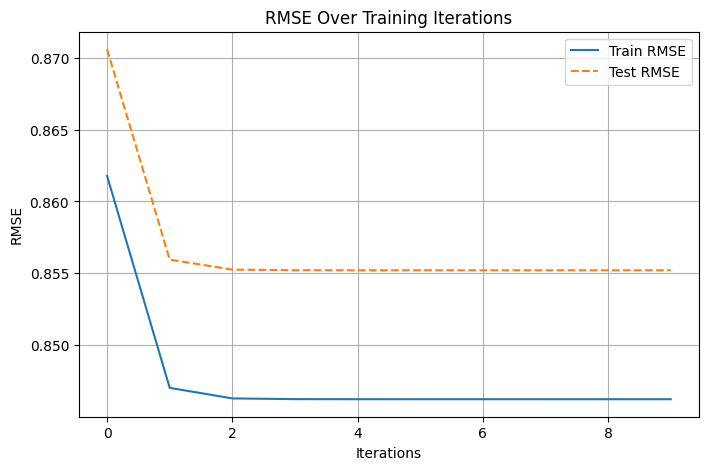

In [ ]:
num_iterations = 10
gamma = 0.001
lambda_reg = 1
M = len(user_lst)
N = len(movie_lst)
user_biases = np.zeros(M)
item_biases = np.zeros(N)


@njit(parallel=True)
def update_user_params(data_by_user_train, item_biases, user_biases, lambda_reg, gamma):
    for user_idx in prange(len(data_by_user_train)):
        bias_sum = 0
        item_counter = 0
        for entry in data_by_user_train[user_idx]:
            movie_idx = entry['movie_idx']
            rating = entry['rating']
            bias_sum += lambda_reg * (rating - item_biases[movie_idx])
            item_counter += 1
        user_biases[user_idx] = bias_sum / (item_counter * lambda_reg + gamma)

@njit(parallel=True)
def update_item_params(data_by_movie_train, user_biases, item_biases,  lambda_reg, gamma):
    for movie_idx in prange(len(data_by_movie_train)):
        bias_sum = 0
        user_counter = 0
        for entry in data_by_movie_train[movie_idx]:
            user_idx = entry['user_idx']
            rating = entry['rating']
            bias_sum += lambda_reg * (rating - user_biases[user_idx])
            user_counter += 1
        item_biases[movie_idx] = bias_sum / (user_counter * lambda_reg + gamma)

@njit
def compute_loss(data, user_biases, item_biases):
    total_loss = 0
    for user_idx in range(len(data)):
        for entry in data[user_idx]:
            movie_idx = entry['movie_idx']
            rating = entry['rating']
            predicted_rating = user_biases[user_idx] + item_biases[movie_idx]
            total_loss += (rating - predicted_rating) ** 2
    return total_loss

@njit
def compute_rmse(data, user_biases, item_biases):
    total_loss = 0
    total_ratings = 0
    for user_idx in range(len(data)):
        for entry in data[user_idx]:
            movie_idx = entry['movie_idx']
            rating = entry['rating']
            predicted_rating = user_biases[user_idx] + item_biases[movie_idx]
            total_loss += (rating - predicted_rating) ** 2
            total_ratings += 1
    return np.sqrt(total_loss / total_ratings)

train_rmse_history = []
test_rmse_history = []
loss_history = []


print("\nStarting training")
for iteration in range(num_iterations):
    start_time = time.time()
    

    update_user_params(data_by_user_train, item_biases, user_biases,lambda_reg, gamma)
    update_item_params(data_by_movie_train, user_biases, item_biases,  lambda_reg, gamma)

    loss = compute_loss(data_by_user_train, user_biases, item_biases)
    train_rmse = compute_rmse(data_by_user_train, user_biases, item_biases)
    test_rmse = compute_rmse(data_by_user_test, user_biases, item_biases)
    
    train_rmse_history.append(train_rmse)
    test_rmse_history.append(test_rmse)

    iteration_time = time.time() - start_time
    print(f"Iteration {iteration + 1}/{num_iterations}, "
          f"Time: {iteration_time:.4f}s, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(train_rmse_history, label='Train RMSE')
plt.plot(test_rmse_history, label='Test RMSE', linestyle='dashed')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.title('RMSE Over Training Iterations')
plt.savefig("images/32M_rmse_bias_only.pdf")
plt.show()


# **BIAS + VECTORS**


Starting training for num_factors=10
Iteration 1/40, Time per iteration: 58.8562 seconds, Train RMSE: 0.9899, Test RMSE: 1.4172
Iteration 2/40, Time per iteration: 35.2238 seconds, Train RMSE: 0.8168, Test RMSE: 0.9502
Iteration 3/40, Time per iteration: 35.2804 seconds, Train RMSE: 0.7608, Test RMSE: 0.9257
Iteration 4/40, Time per iteration: 34.9396 seconds, Train RMSE: 0.7426, Test RMSE: 0.9076
Iteration 5/40, Time per iteration: 35.6405 seconds, Train RMSE: 0.7333, Test RMSE: 0.8958
Iteration 6/40, Time per iteration: 36.1395 seconds, Train RMSE: 0.7281, Test RMSE: 0.8859
Iteration 7/40, Time per iteration: 35.5876 seconds, Train RMSE: 0.7243, Test RMSE: 0.8789
Iteration 8/40, Time per iteration: 35.8012 seconds, Train RMSE: 0.7217, Test RMSE: 0.8730
Iteration 9/40, Time per iteration: 34.8229 seconds, Train RMSE: 0.7196, Test RMSE: 0.8684
Iteration 10/40, Time per iteration: 35.8152 seconds, Train RMSE: 0.7180, Test RMSE: 0.8644
Iteration 11/40, Time per iteration: 37.2586 second

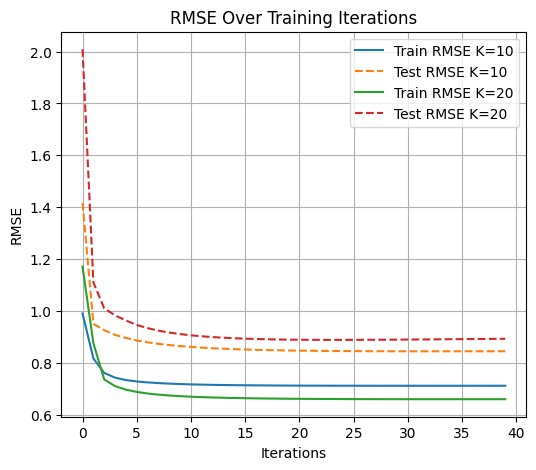

In [ ]:
# Initialize parameters
k_list = [10, 20]
num_iterations = 40
gamma = 0.001
lambda_reg = 1
tau = 1
M = len(user_lst)
N = len(movie_lst)

# the update functions for parallel updates and RMSE computation
@njit(parallel=True)
def update_user_params(data_by_user_train, user_vectors, item_vectors, item_biases, user_biases, k, lambda_reg, tau):
    for user_idx in prange(len(data_by_user_train)):
        bias_sum = 0
        item_counter = 0
        A = np.zeros((k, k))
        b = np.zeros(k)
        for entry in data_by_user_train[user_idx]:
            movie_idx = entry['movie_idx']
            rating = entry['rating']
            bias_sum += lambda_reg * (rating - item_biases[movie_idx] - np.dot(user_vectors[user_idx], item_vectors[movie_idx]))
            item_counter += 1
            prediction_error = rating - user_biases[user_idx] - item_biases[movie_idx]
            A += np.outer(item_vectors[movie_idx], item_vectors[movie_idx])
            b += prediction_error * item_vectors[movie_idx]
        user_biases[user_idx] = bias_sum / (item_counter * lambda_reg + tau)
        user_vectors[user_idx] = np.linalg.solve(lambda_reg * A + tau * np.eye(k), lambda_reg * b)

@njit(parallel=True)
def update_item_params(data_by_movie_train, user_vectors, item_vectors, user_biases, item_biases, k, lambda_reg, tau):
    for movie_idx in prange(len(data_by_movie_train)):
        bias_sum = 0
        user_counter = 0
        A = np.zeros((k, k))
        b = np.zeros(k)
        for entry in data_by_movie_train[movie_idx]:
            user_idx = entry['user_idx']
            rating = entry['rating']
            bias_sum += lambda_reg * (rating - user_biases[user_idx] - np.dot(user_vectors[user_idx], item_vectors[movie_idx]))
            user_counter += 1
            prediction_error = rating - user_biases[user_idx] - item_biases[movie_idx]
            A += np.outer(user_vectors[user_idx], user_vectors[user_idx])
            b += prediction_error * user_vectors[user_idx]
        item_biases[movie_idx] = bias_sum / (user_counter * lambda_reg + tau)
        item_vectors[movie_idx] = np.linalg.solve(lambda_reg * A + tau * np.eye(k), lambda_reg * b)


@njit
def compute_rmse(data, user_vectors, item_vectors, user_biases, item_biases, lambda_reg, gamma, tau):
    total_loss = 0
    total_ratings = 0
     
    for user_idx in range(len(data)):
        for entry in data[user_idx]:
            movie_idx = entry[0]  
            rating = entry[1]     
            predicted_rating = (
                user_biases[user_idx] + 
                item_biases[movie_idx] + 
                np.dot(user_vectors[user_idx], item_vectors[movie_idx])
            )
            total_loss += (rating - predicted_rating) ** 2
            total_ratings += 1
    reg_loss = (
        gamma * (np.sum(user_biases ** 2) + np.sum(item_biases ** 2)) +
        tau * (np.sum(user_vectors ** 2) + np.sum(item_vectors ** 2))
    )
    total_loss += lambda_reg * reg_loss
    return np.sqrt(total_loss / total_ratings)


train_rmse_history = {k: [] for k in k_list}
test_rmse_history = {k: [] for k in k_list}

# Main loop 
for k in k_list:
    user_biases = np.zeros(M)
    item_biases = np.zeros(N)
    user_vectors = np.random.normal(0, 1 / np.sqrt(k), (M, k))
    item_vectors = np.random.normal(0, 1 / np.sqrt(k), (N, k))

    print(f"\nStarting training for k={k}")
    for iteration in range(num_iterations):
        start_time = time.time()
        
        # Update user and item parameters
        update_user_params(data_by_user_train, user_vectors, item_vectors, item_biases, user_biases, k, lambda_reg, tau)
        update_item_params(data_by_movie_train, user_vectors, item_vectors, user_biases, item_biases, k, lambda_reg, tau)

        
        train_rmse = compute_rmse(data_by_user_train, user_vectors, item_vectors, user_biases, item_biases,lambda_reg,gamma,tau)
        test_rmse = compute_rmse(data_by_user_test, user_vectors, item_vectors, user_biases, item_biases,lambda_reg,gamma,tau)
        train_rmse_history[k].append(train_rmse)
        test_rmse_history[k].append(test_rmse)

       
        end_time = time.time()
        iteration_time = end_time - start_time
        print(f"Iteration {iteration + 1}/{num_iterations}, Time per iteration: {iteration_time:.4f} seconds, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")


plt.figure(figsize=(6, 5))
for k in k_list:
    plt.plot(train_rmse_history[k], label=f'Train RMSE K={k}')
    plt.plot(test_rmse_history[k], label=f'Test RMSE K={k}', linestyle='dashed')

plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.title('RMSE Over Training Iterations')
plt.savefig("images/32M_rmse_bias_latent_factors_with_different_kp_1.pdf")
plt.show()


# **2D EMBEDDINGS MOVIES**

In [27]:
from sklearn.decomposition import PCA
import seaborn as sns

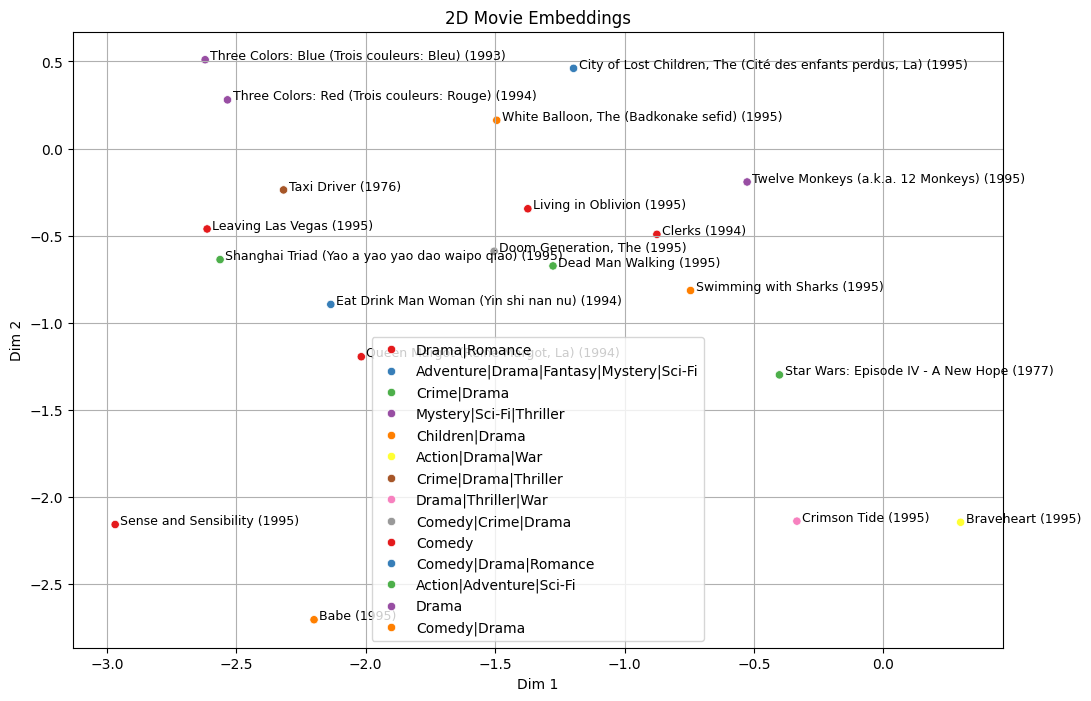

In [ ]:
# reduce dimensionality of item vectors to 2D using PCA
pca = PCA(n_components=2)
item_vectors_2d = pca.fit_transform(item_vectors)

# movie titles
movie_titles = {row['movieId']: row['title'] for _, row in df_movie.iterrows()}
mapped_titles = [movie_titles.get(movie_lst[movie_idx], "Unknown") for movie_idx in range(len(item_vectors_2d))]

genres = {row['movieId']: row['genres'] for _, row in df_movie.iterrows()}
movie_genres = [genres.get(movie_lst[movie_idx], "Unknown") for movie_idx in range(len(item_vectors_2d))]


N = 20  # number of movies we want to visualize
plt.figure(figsize=(12, 8))

sns.scatterplot(
    x=item_vectors_2d[:N, 0],
    y=item_vectors_2d[:N, 1],
    hue=movie_genres[:N],
    palette="Set1", 
    legend="full",
)

for i in range(N):
    plt.text(item_vectors_2d[i, 0] + 0.02, item_vectors_2d[i, 1], mapped_titles[i], fontsize=9)

plt.title("2D Movie Embeddings")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.savefig("images/2D_embedding_movie.pdf")
plt.show()


# **ADD FEATURES**

In [32]:
import numpy as np
from numba import njit, prange
from numba.typed import List
import matplotlib.pyplot as plt

In [31]:
# feature encoding
genres = sorted(list(set('|'.join(list(df_movie['genres'])).split('|'))))
num_genres = len(genres)
dict_genres = {genre: idx for idx, genre in enumerate(genres)}

# Create the feature list for movies
features_per_movies = [[] for _ in range(len(movie_lst))]
for i, movie_id in enumerate(movie_lst):
    genres_per_movie = df_movie.loc[df_movie['movieId'] == movie_id, 'genres'].values[0].split('|')
    for genre in genres_per_movie:
        features_per_movies[i].append(dict_genres[genre])

# Convert features_per_movies to numba.typed.List
features_per_movies_typed = List()
for feature_list in features_per_movies:
    features_per_movies_typed.append(np.array(feature_list, dtype=np.int32))
features_per_movies=features_per_movies_typed
# movies with each feature
movies_with_feature_i = [[] for _ in range(num_genres)]
for i in range(num_genres):
    for n in range(len(movie_lst)):
        if i in features_per_movies[n]:
            movies_with_feature_i[i].append(n)

# Convert movies_with_feature_i to numba.typed.List
movies_with_feature_i_typed = List()
for movie_list in movies_with_feature_i:
    movies_with_feature_i_typed.append(np.array(movie_list, dtype=np.int32))
movies_with_feature_i=movies_with_feature_i_typed


Starting training for k=10
Iteration 1/40, Time per iteration: 55.5030 seconds, Train RMSE: 1.0040, Test RMSE: 1.3346
Iteration 2/40, Time per iteration: 36.6172 seconds, Train RMSE: 0.8320, Test RMSE: 0.9663
Iteration 3/40, Time per iteration: 37.8340 seconds, Train RMSE: 0.7614, Test RMSE: 0.9200
Iteration 4/40, Time per iteration: 37.5815 seconds, Train RMSE: 0.7410, Test RMSE: 0.9000
Iteration 5/40, Time per iteration: 36.1517 seconds, Train RMSE: 0.7307, Test RMSE: 0.8870
Iteration 6/40, Time per iteration: 36.0327 seconds, Train RMSE: 0.7248, Test RMSE: 0.8761
Iteration 7/40, Time per iteration: 36.6647 seconds, Train RMSE: 0.7207, Test RMSE: 0.8687
Iteration 8/40, Time per iteration: 36.5439 seconds, Train RMSE: 0.7180, Test RMSE: 0.8624
Iteration 9/40, Time per iteration: 36.3171 seconds, Train RMSE: 0.7158, Test RMSE: 0.8578
Iteration 10/40, Time per iteration: 36.0357 seconds, Train RMSE: 0.7142, Test RMSE: 0.8537
Iteration 11/40, Time per iteration: 36.5442 seconds, Train R

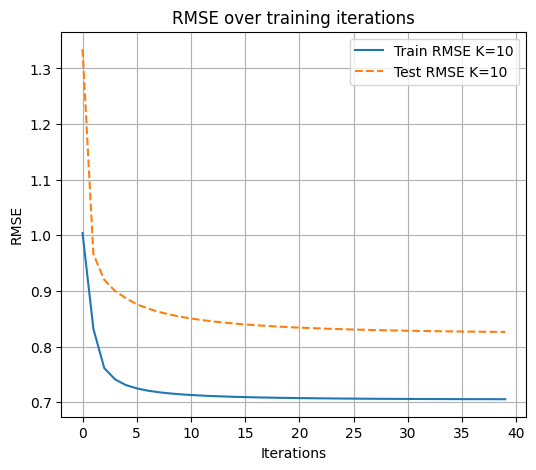

In [34]:
k=10
num_iterations = 40
gamma = 0.001
lambda_reg = 2
tau = 1
M = len(data_by_user_train)  
N = len(data_by_movie_train)  
tau_feat = 0.01



# we update in parallel
@njit(parallel=True)
def update_user_params(data_by_user_train, user_vectors, item_vectors, item_biases, user_biases, k, lambda_reg, tau):
    for user_idx in prange(len(data_by_user_train)):
        bias_sum = 0
        item_counter = 0
        A = np.zeros((k, k))
        b = np.zeros(k)
        for entry in data_by_user_train[user_idx]:
            movie_idx = entry['movie_idx']
            rating = entry['rating']
            bias_sum += lambda_reg * (rating - item_biases[movie_idx] - np.dot(user_vectors[user_idx], item_vectors[movie_idx]))
            item_counter += 1
            prediction_error = rating - user_biases[user_idx] - item_biases[movie_idx]
            A += np.outer(item_vectors[movie_idx], item_vectors[movie_idx])
            b += prediction_error * item_vectors[movie_idx]
        user_biases[user_idx] = bias_sum / (item_counter * lambda_reg + tau)
        user_vectors[user_idx] = np.linalg.solve(lambda_reg * A + tau * np.eye(k), lambda_reg * b)

@njit(parallel=True)
def update_item_params(data_by_movie_train, user_vectors, item_vectors, user_biases, item_biases,feature_vec, features_per_movies, tau_feat, k, lambda_reg, tau):
    for movie_idx in prange(len(data_by_movie_train)):
        bias_sum = 0
        user_counter = 0
        A = np.zeros((k, k))
        b = np.zeros(k)
        for entry in data_by_movie_train[movie_idx]:
            user_idx = entry['user_idx']
            rating = entry['rating']
            bias_sum += lambda_reg * (rating - user_biases[user_idx] - np.dot(user_vectors[user_idx], item_vectors[movie_idx]))
            user_counter += 1
            prediction_error = rating - user_biases[user_idx] - item_biases[movie_idx]
            A += np.outer(user_vectors[user_idx], user_vectors[user_idx])
            b += prediction_error * user_vectors[user_idx]
        item_biases[movie_idx] = bias_sum / (user_counter * lambda_reg + tau)
        add = tau_feat * np.sum(feature_vec[features_per_movies[movie_idx], :], axis=0) / np.sqrt(len(features_per_movies[movie_idx]))
        item_vectors[movie_idx] = np.linalg.solve(lambda_reg * A + tau * np.eye(k), lambda_reg * b+add)

@njit(parallel=True)
def update_feature_vectors(item_vectors, feature_vectors, features_per_movies, num_genres, tau, tau_feat, movies_with_feature_i):
    for i in prange(num_genres):
        denominator = tau_feat  
        for n in movies_with_feature_i[i]:
            denominator += tau * (1.0 / np.sqrt(len(features_per_movies[n])))  
        feature_vectors[i, :] = tau * np.sum(item_vectors[movies_with_feature_i[i], :], axis=0) / denominator

    return feature_vectors


@njit
def compute_rmse(data, user_vectors, item_vectors, user_biases, item_biases, feature_vectors, features_per_movies, N, lambda_reg, tau, tau_feat, gamma):
    total_loss = 0
    total_ratings = 0

    for user_idx in range(len(data)):
        for entry in data[user_idx]:
            movie_idx = entry['movie_idx']
            rating = entry['rating']
            predicted_rating = user_biases[user_idx] + item_biases[movie_idx] + np.dot(user_vectors[user_idx], item_vectors[movie_idx])
            total_loss += (rating - predicted_rating) ** 2
            total_ratings += 1
    feat_vec1 = np.zeros((N, user_vectors.shape[1]))  
    feat_vec2 = np.zeros((N, user_vectors.shape[1]))

    for n in range(N):
        feat_vec1[n, :] = np.sum(feature_vectors[features_per_movies[n], :], axis=0) / np.sqrt(len(features_per_movies[n]))
        feat_vec2[n, :] = np.sum(feature_vectors[features_per_movies[n], :], axis=0)

    loss = 0.5 * lambda_reg * total_loss + 0.5 * tau * (np.sum(user_vectors ** 2) + np.sum((item_vectors - feat_vec1) ** 2)) + \
       0.5 * tau_feat * np.sum(feat_vec2 ** 2) + 0.5 * gamma * (np.sum(user_biases ** 2) + np.sum(item_biases ** 2))

    rmse = np.sqrt(loss / total_ratings)
    return rmse



train_rmse_history = {k: [] for k in k_list}
test_rmse_history = {k: [] for k in k_list}


user_biases = np.zeros(M)
item_biases = np.zeros(N)
user_vectors = np.random.normal(0, 1 / np.sqrt(k), (M, k))
item_vectors = np.random.normal(0, 1 / np.sqrt(k), (N, k))
feature_vectors = np.random.normal(0, 1 / np.sqrt(k), (num_genres, k))

print(f"\nStarting training for k={k}")
for iteration in range(num_iterations):
    start_time = time.time()
    
    # Update user and item parameters
    update_user_params(data_by_user_train, user_vectors, item_vectors, item_biases, user_biases, k, lambda_reg, tau)
    update_item_params(data_by_movie_train, user_vectors, item_vectors, user_biases, item_biases,feature_vectors, features_per_movies,tau_feat , k, lambda_reg, tau)
    
    feature_vectors = update_feature_vectors(item_vectors, feature_vectors, features_per_movies, num_genres, tau, tau_feat, movies_with_feature_i)

    train_rmse = compute_rmse(data_by_user_train, user_vectors, item_vectors, user_biases, item_biases, 
                            feature_vectors, features_per_movies, N, lambda_reg, tau, tau_feat, gamma)

    test_rmse = compute_rmse(data_by_user_test, user_vectors, item_vectors, user_biases, item_biases, 
                            feature_vectors, features_per_movies, N, lambda_reg, tau, tau_feat, gamma)

    train_rmse_history[k].append(train_rmse)
    test_rmse_history[k].append(test_rmse)

    end_time = time.time()
    iteration_time = end_time - start_time
    print(f"Iteration {iteration + 1}/{num_iterations}, Time per iteration: {iteration_time:.4f} seconds, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

# Plot 
plt.figure(figsize=(6, 5))

plt.plot(train_rmse_history[k], label=f'Train RMSE K={k}')
plt.plot(test_rmse_history[k], label=f'Test RMSE K={k}', linestyle='dashed')

plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.title('RMSE over training iterations')
plt.savefig("images/32M_rmse_bias_latent_factors_with_features.pdf")
plt.show()


# **TRAINING ON FULL DATASET(32M)**

In [35]:

movie_index_dict = {}
user_index_dict = {}
user_lst = []
movie_lst = []


for user, movie, rating in zip(users, movies, ratings):
 
    if user not in user_index_dict:
        n = len(user_lst)
        user_index_dict[user] = n
        user_lst.append(user)

   
    if movie not in movie_index_dict:
        m = len(movie_lst)
        movie_index_dict[movie] = m
        movie_lst.append(movie)


M = len(user_lst)  
N = len(movie_lst) 
user_movie_ratings = []
for user, movie, rating in zip(users, movies, ratings):
    user_index = user_index_dict[user]
    movie_index = movie_index_dict[movie]
    user_movie_ratings.append((user_index, movie_index, rating))  

user_movie_ratings = np.array(user_movie_ratings, dtype=[('user_idx', np.int32), ('movie_idx', np.int32), ('rating', np.float64)])

data_by_user= [[] for _ in range(M)]
data_by_movie= [[] for _ in range(N)]

for user, movie, rating in zip(users, movies, ratings):
    user_index = user_index_dict[user]
    movie_index = movie_index_dict[movie]
    data_by_user[user_index].append((movie_index, rating))
    data_by_movie[movie_index].append((user_index, rating))
                                            
data_by_user= [np.array(data, dtype=[('movie_idx', np.int32), ('rating', np.float64)]) for data in data_by_user]
data_by_movie= [np.array(data, dtype=[('user_idx', np.int32), ('rating', np.float64)]) for data in data_by_movie]


In [6]:
len(data_by_user),len(data_by_movie)

(200948, 84432)

In [9]:
k = 10  
num_iterations = 50
gamma = 0.8
lambda_reg = 0.8
tau = 0.8
@njit(parallel=True)
def update_user_params(data_by_user, user_vectors, item_vectors, item_biases, user_biases, k, lambda_reg, tau):
    for user_idx in prange(len(data_by_user)):
        bias_sum = 0
        item_counter = 0
        A = np.zeros((k, k))
        b = np.zeros(k)
        for entry in data_by_user[user_idx]:
            movie_idx = entry['movie_idx']
            rating = entry['rating']
            bias_sum += lambda_reg * (rating - item_biases[movie_idx] - np.dot(user_vectors[user_idx], item_vectors[movie_idx]))
            item_counter += 1
            prediction_error = rating - user_biases[user_idx] - item_biases[movie_idx]
            A += np.outer(item_vectors[movie_idx], item_vectors[movie_idx])
            b += prediction_error * item_vectors[movie_idx]
        user_biases[user_idx] = bias_sum / (item_counter * lambda_reg + tau)
        user_vectors[user_idx] = np.linalg.solve(lambda_reg * A + tau * np.eye(k), lambda_reg * b)

@njit(parallel=True)
def update_item_params(data_by_movie, user_vectors, item_vectors, user_biases, item_biases, k, lambda_reg, tau):
    for movie_idx in prange(len(data_by_movie)):
        bias_sum = 0
        user_counter = 0
        A = np.zeros((k, k))
        b = np.zeros(k)
        for entry in data_by_movie[movie_idx]:
            user_idx = entry['user_idx']
            rating = entry['rating']
            bias_sum += lambda_reg * (rating - user_biases[user_idx] - np.dot(user_vectors[user_idx], item_vectors[movie_idx]))
            user_counter += 1
            prediction_error = rating - user_biases[user_idx] - item_biases[movie_idx]
            A += np.outer(user_vectors[user_idx], user_vectors[user_idx])
            b += prediction_error * user_vectors[user_idx]
        item_biases[movie_idx] = bias_sum / (user_counter * lambda_reg + tau)
        item_vectors[movie_idx] = np.linalg.solve(lambda_reg * A + tau * np.eye(k), lambda_reg * b)

@njit
def compute_rmse(data, user_vectors, item_vectors, user_biases, item_biases):
    total_loss = 0
    total_ratings = 0
    for user_idx in range(len(data)):
        for entry in data[user_idx]:
            movie_idx = entry['movie_idx']
            rating = entry['rating']
            predicted_rating = user_biases[user_idx] + item_biases[movie_idx] + np.dot(user_vectors[user_idx], item_vectors[movie_idx])
            total_loss += (rating - predicted_rating) ** 2
            total_ratings += 1
    return np.sqrt(total_loss / total_ratings)

train_rmse_history = []

# Main loop with timing
user_biases = np.zeros(M)
item_biases = np.zeros(N)
user_vectors = np.random.normal(0, 1 / np.sqrt(k), (M, k))
item_vectors = np.random.normal(0, 1 / np.sqrt(k), (N, k))

print(f"\nStarting training for k={k}")
for iteration in range(num_iterations):
    start_time = time.time()
    

    update_user_params(data_by_user, user_vectors, item_vectors, item_biases, user_biases, k, lambda_reg, tau)
    update_item_params(data_by_movie, user_vectors, item_vectors, user_biases, item_biases, k, lambda_reg, tau)

   
    train_rmse = compute_rmse(data_by_user, user_vectors, item_vectors, user_biases, item_biases)
    train_rmse_history.append(train_rmse)

    
    end_time = time.time()
    iteration_time = end_time - start_time
    print(f"Iteration {iteration + 1}/{num_iterations}", 
          f"Time per iteration: {iteration_time:.4f} seconds, Train RMSE: {train_rmse:.4f}")



Starting training for num_factors=10
Iteration 1/50, Time per iteration: 60.4877 seconds, Train RMSE: 0.9235
Iteration 2/50, Time per iteration: 30.2896 seconds, Train RMSE: 0.7997
Iteration 3/50, Time per iteration: 30.2005 seconds, Train RMSE: 0.7449
Iteration 4/50, Time per iteration: 32.1812 seconds, Train RMSE: 0.7288
Iteration 5/50, Time per iteration: 31.2838 seconds, Train RMSE: 0.7206
Iteration 6/50, Time per iteration: 30.8084 seconds, Train RMSE: 0.7167
Iteration 7/50, Time per iteration: 31.7882 seconds, Train RMSE: 0.7138
Iteration 8/50, Time per iteration: 30.6791 seconds, Train RMSE: 0.7123
Iteration 9/50, Time per iteration: 30.6942 seconds, Train RMSE: 0.7109
Iteration 10/50, Time per iteration: 31.5652 seconds, Train RMSE: 0.7101
Iteration 11/50, Time per iteration: 31.4017 seconds, Train RMSE: 0.7094
Iteration 12/50, Time per iteration: 31.1525 seconds, Train RMSE: 0.7090
Iteration 13/50, Time per iteration: 30.1110 seconds, Train RMSE: 0.7085
Iteration 14/50, Time 

In [12]:
import pickle

In [14]:
def save_als_model(filename, user_biases, item_biases, user_vectors, item_vectors):
    model_data = {
        'user_biases': user_biases,
        'item_biases': item_biases,
        'user_vectors': user_vectors,
        'item_vectors': item_vectors
    }
    with open(filename, 'wb') as f:
        pickle.dump(model_data, f)
    print(f"Model saved to {filename}")


save_als_model('model_als.pkl', user_biases, item_biases, user_vectors, item_vectors)


Model saved to model_als.pkl


In [27]:
# load from pickle file
def load_als_model(filename):
    with open(filename, 'rb') as f:
        model_data = pickle.load(f)
    print(f"Model loaded from {filename}")
    return model_data['user_biases'], model_data['item_biases'], model_data['user_vectors'], model_data['item_vectors']


user_biases, item_biases, user_vectors, item_vectors = load_als_model('model_als.pkl')


Model loaded from model_als.pkl


In [16]:

lord_of_the_rings_movies = df_movie[df_movie['title'].str.contains('Lord of the Rings', case=False, na=False)]
print("Movies with 'Lord of the Rings' in the title:")
lord_of_the_rings_movies[['movieId', 'title']].reset_index(drop=True)


Movies with 'Lord of the Rings' in the title:


,movieId,title
0,2116,"Lord of the Rings, The (1978)"
1,4993,"Lord of the Rings: The Fellowship of the Ring,..."
2,5952,"Lord of the Rings: The Two Towers, The (2002)"
3,7153,"Lord of the Rings: The Return of the King, The..."
4,231829,A Passage to Middle-earth: Making of 'Lord of ...
5,267392,"J.R.R. Tolkien and the Birth Of ""The Lord of t..."


In [26]:
def compute_dummy_user_vector(dummy_user_ratings, item_vectors, item_biases, lambda_reg=0.01, tau=0.1):
    A = np.array([item_vectors[movie_idx] for (movie_idx, _) in dummy_user_ratings])
    b = np.array([rating - item_biases[movie_idx] for (movie_idx, rating) in dummy_user_ratings])
    ATA = lambda_reg * np.dot(A.T, A) + tau * lambda_reg * np.eye(A.shape[1])
    ATb = np.dot(A.T, b)
    user_vector = np.linalg.solve(ATA, ATb)
    
    return user_vector
def calculate_movie_ratings_count(data_by_movie):
    return [len(movie_data) for movie_data in data_by_movie]

def rank_movies_for_dummy_user(dummy_user_vector, item_vectors, item_biases, ratings_count, min_ratings=100, top_n=20):
    scores = []  
    for movie_idx in range(len(item_vectors)):
        if ratings_count[movie_idx] >= min_ratings:
            score = np.dot(dummy_user_vector, item_vectors[movie_idx]) + 0.05 * item_biases[movie_idx]
            scores.append((movie_idx, score)) 
    ranked_movies = sorted(scores, key=lambda x: x[1], reverse=True)
    
    return ranked_movies[:top_n]

dummy_user_id = len(user_lst)
user_lst.append(dummy_user_id)

movie_title = 'lord of the rings'
movie_df = df_movie[df_movie['title'].str.contains(movie_title, case=False, na=False)]
movie_id = movie_df['movieId'].iloc[1]
movie_index = movie_index_dict.get(movie_id)


dummy_user_ratings = [(movie_index, 5.0)]
if dummy_user_id >= len(data_by_user):
    data_by_user.extend([[] for _ in range(dummy_user_id - len(data_by_user) + 1)])
data_by_user[dummy_user_id] = dummy_user_ratings

existing_ratings = data_by_movie[movie_index].tolist()
existing_ratings.append((dummy_user_id, 5.0))
data_by_movie[movie_index] = np.array(existing_ratings, dtype=[('user_idx', np.int32), ('rating', np.float64)])

dummy_user_vector = compute_dummy_user_vector(dummy_user_ratings, item_vectors, item_biases)
ratings_count = calculate_movie_ratings_count(data_by_movie)

top_recommendations = rank_movies_for_dummy_user(dummy_user_vector, item_vectors, item_biases, ratings_count)

print("Personalized Recommendations for Dummy User:")
personalized_movie_ids = [movie_lst[i[0]] for i in top_recommendations]
personalized_movies_df = df_movie[df_movie['movieId'].isin(personalized_movie_ids)]
personalized_movies_df = personalized_movies_df.set_index('movieId').loc[personalized_movie_ids].reset_index()
personalized_movies_df[['title', 'genres']]


Personalized Recommendations for Dummy User:


,title,genres
0,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
1,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
2,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
3,"Hobbit: An Unexpected Journey, The (2012)",Adventure|Fantasy|IMAX
4,"Hobbit: The Desolation of Smaug, The (2013)",Adventure|Fantasy|IMAX
5,Star Wars: Episode II - Attack of the Clones (...,Action|Adventure|Sci-Fi|IMAX
6,Star Wars: Episode III - Revenge of the Sith (...,Action|Adventure|Sci-Fi
7,The Hobbit: The Battle of the Five Armies (2014),Adventure|Fantasy
8,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi
9,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi


# POLARISATION

In [29]:
# Find polarizing movies
distances = np.linalg.norm(item_vectors, axis=1)
top_10_indices = np.argsort(distances)[-10:]  # Most polarizing
bottom_10_indices = np.argsort(distances)[:10]  # Least polarizing

# Get titles for most and least polarizing movies
most_polarizing_movies = [df_movie.loc[df_movie['movieId'] == movie_lst[i], 'title'].values[0] for i in top_10_indices]
least_polarizing_movies = [df_movie.loc[df_movie['movieId'] == movie_lst[i], 'title'].values[0] for i in bottom_10_indices]

print("Most Polarizing Movies:", most_polarizing_movies)
print("Least Polarizing Movies:", least_polarizing_movies)

Most Polarizing Movies: ['Saw VII 3D - The Final Chapter (2010)', 'Spider-Man: Across the Spider-Verse (2023)', 'Saw V (2008)', 'Saw (2004)', 'Saw VI (2009)', 'Saw II (2005)', 'Saw IV (2007)', 'Avengers: Infinity War - Part I (2018)', 'Saw III (2006)', 'Avengers: Infinity War - Part II (2019)']
Least Polarizing Movies: ['Video Surveillance (2012)', 'Miss Gold Digger (2007)', 'Endgame (2021)', 'Finders Keepers, Lovers Weepers (1968)', 'Trying to Get Arrested (1909)', 'All Creatures Great and Small (1975)', 'Goosed (1999)', 'Snow Canon (2011)', 'Ceiling (1962)', 'Transport from Paradise (1963)']


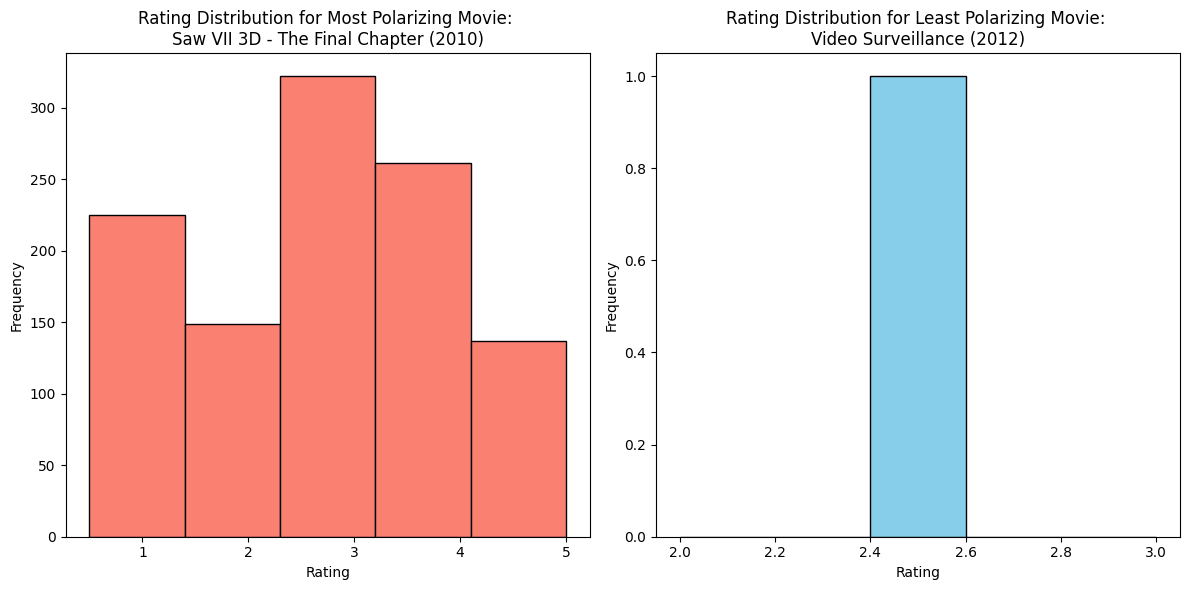

In [40]:
most_polarizing_id = movie_lst[top_10_indices[0]]
least_polarizing_id = movie_lst[bottom_10_indices[0]]


most_polarizing_ratings = df_rating[df_rating['movieId'] == most_polarizing_id]['rating']
least_polarizing_ratings = df_rating[df_rating['movieId'] == least_polarizing_id]['rating']


most_polarizing_title = df_movie.loc[df_movie['movieId'] == most_polarizing_id, 'title'].values[0]
least_polarizing_title = df_movie.loc[df_movie['movieId'] == least_polarizing_id, 'title'].values[0]


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.hist(most_polarizing_ratings, bins=5, edgecolor='black', color='salmon')
plt.title(f'Rating Distribution for Most Polarizing Movie: \n{most_polarizing_title}')
plt.xlabel('Rating')
plt.ylabel('Frequency')


plt.subplot(1, 2, 2)
plt.hist(least_polarizing_ratings, bins=5, edgecolor='black', color='skyblue')
plt.title(f'Rating Distribution for Least Polarizing Movie: \n{least_polarizing_title}')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig("Most_least_polarizing_movies.pdf")
plt.show()


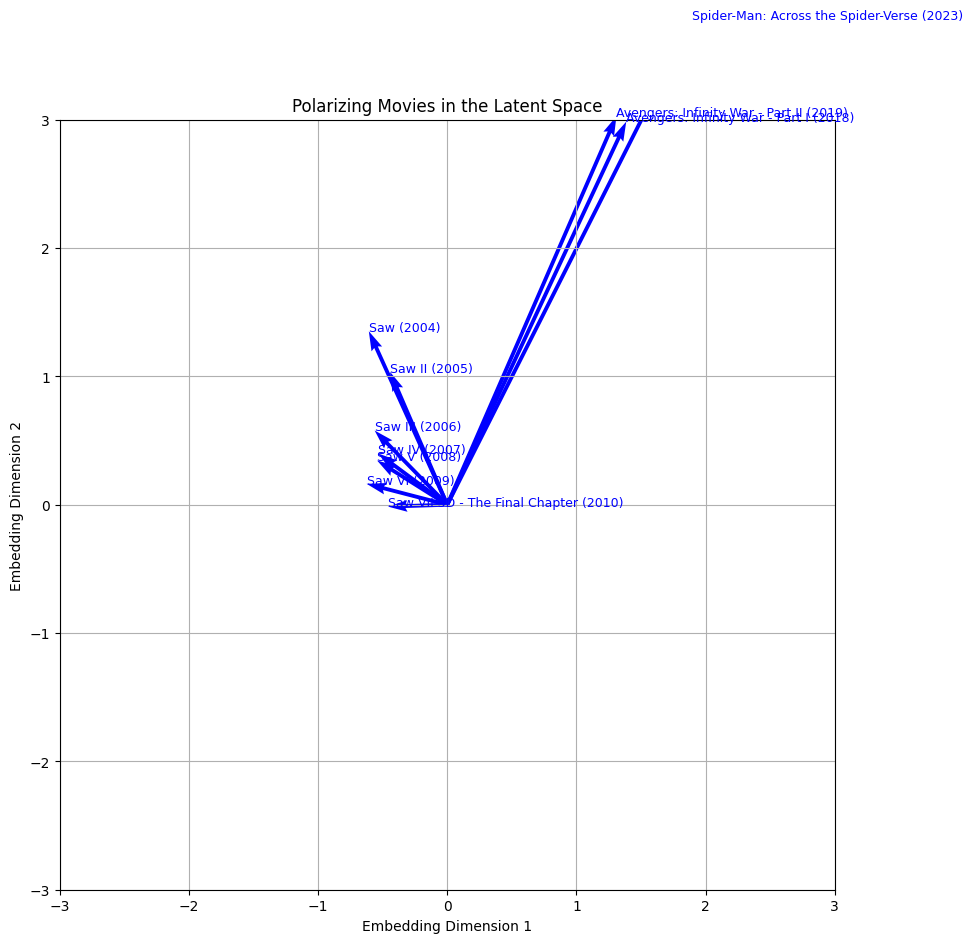

In [41]:

plt.figure(figsize=(10, 10))
plt.quiver(np.zeros(len(top_10_indices)), np.zeros(len(top_10_indices)),
           item_vectors[top_10_indices, 0], item_vectors[top_10_indices, 1],
           angles='xy', scale_units='xy', scale=1, color='b', width=0.005, label='Most Polarizing')

for i in top_10_indices:
    plt.text(item_vectors[i, 0], item_vectors[i, 1], df_movie.loc[df_movie['movieId'] == movie_lst[i], 'title'].values[0], fontsize=9, color='blue')

plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.grid(True)
plt.title('Polarizing Movies in the Latent Space')
plt.savefig('Most_polarizing_movies.pdf', bbox_inches='tight')

In [414]:
import numpy as np

def top_polarizing_movies_by_distance(item_vectors, top_n=10):
    movie_distances = np.linalg.norm(item_vectors, axis=1)
    
    top_indices = np.argsort(movie_distances)[-top_n:][::-1]  
    
    return top_indices

top_polarizing_movies_indices = top_polarizing_movies_by_distance(item_vectors, top_n=10)

top_polarizing_movies_titles = df_movie.iloc[top_polarizing_movies_indices]['title']
print("Top 10 Most Polarizing Movies Based on Distance from Origin:")
print(top_polarizing_movies_titles)


Top 10 Most Polarizing Movies Based on Distance from Origin:
3715     Other Side of Sunday, The (Søndagsengler) (1996)
4872                                       Lantana (2001)
4942                                     Snow Dogs (2002)
4869                                   Vanilla Sky (2001)
1797                             I Got the Hook Up (1998)
4903                                           Ali (2001)
5057                         StageFright: Aquarius (1987)
400     Highlander III: The Sorcerer (a.k.a. Highlande...
5169                         Evil That Men Do, The (1984)
532                                         Sirens (1994)
Name: title, dtype: object


In [397]:
def calculate_movie_stats(data_by_movie):
    movie_means = []
    movie_stds = []
    for movie_data in data_by_movie:
        if len(movie_data) > 0:
            ratings = movie_data['rating']
            movie_means.append(ratings.mean())
            movie_stds.append(ratings.std())
    
    return movie_means, movie_stds


movie_means, movie_stds = calculate_movie_stats(data_by_movie)


polarizing_threshold = 2.0
polarizing_indices = np.where(np.array(movie_stds) > polarizing_threshold)[0]
polarizing_movies = [(movie_lst[i], movie_means[i], movie_stds[i]) for i in polarizing_indices]
polarizing_movies_df = pd.DataFrame(polarizing_movies, columns=['movieId', 'mean_rating', 'std_dev'])

polarizing_movies_df = polarizing_movies_df.merge(df_movie[['movieId', 'title', 'genres']], on='movieId')
print("Most Polarizing Movies:")
polarizing_movies_df[['title', 'genres', 'mean_rating', 'std_dev']].sort_values(by='std_dev', ascending=False).head(10)




Most Polarizing Movies:


,title,genres,mean_rating,std_dev
0,Balance of Power (1996),Action|Thriller,2.75,2.25
2,Jurassic Attack (2012),Action|Sci-Fi,2.75,2.25
5,Stone Cold Steve Austin: The Bottom Line on th...,Documentary,2.75,2.25
4,Dark Moon Rising (2015),Fantasy|Horror,2.75,2.25
10,Anomaly (2016),Horror|Mystery|Sci-Fi,2.75,2.25
11,Key (2011),(no genres listed),2.75,2.25
9,The Cradle (2007),Horror|Thriller,2.75,2.25
8,Atrocity (2014),(no genres listed),2.75,2.25
23,Cinema Six (2013),(no genres listed),2.75,2.25
18,Raise Hell: The Life & Times of Molly Ivins (2...,Documentary,2.75,2.25
